# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
from lakemodel_function import lake_problem
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from lakemodel_function import lake_problem
from ema_workbench.analysis import prim
from SALib.analyze import sobol

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Setup the model
lake_model = Model('Lakemodel', function=lake_problem)

lake_model.uncertainties = [RealParameter('b',0.1,0.45),
                           RealParameter('q',2.0,4.5),
                           RealParameter('mean',0.01,0.05),
                           RealParameter('stdev',0.001,0.005),
                           RealParameter('delta',0.93,0.99)]

lake_model.levers = [RealParameter('l'+str(i),0,0.1) for i in range(100)]

lake_model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('intertia'),
                  ScalarOutcome('reliability')]

In [3]:
# Defining three policies
policy = [Policy('0', **{l.name:0 for l in lake_model.levers}),
          Policy('0.05', **{l.name:0.05 for l in lake_model.levers}),
          Policy('0.1', **{l.name:0.1 for l in lake_model.levers})]

In [4]:
policy = [Policy('0', **{'l'+str(i):0 for i in range(100)}),
          Policy('0.05', **{'l'+str(i):0.05 for i in range(100)}),
          Policy('0.1', **{'l'+str(i):0.1 for i in range(100)})]

In [5]:
# Perform the Sobol sensitivity analysis
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment, result = evaluator.perform_experiments(
                                         scenarios=1000,
                                         policies = policy, 
                                         uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
experiment['reliability'] = result['reliability']

In [7]:
policy0 = experiment[experiment['policy'] == '0']
policy005 = experiment[experiment['policy'] == '0.05']
policy01 = experiment[experiment['policy'] == '0.1']
policy01

,b,delta,mean,q,stdev,l0,l1,l2,l3,l4,...,l94,l95,l96,l97,l98,l99,scenario,policy,model,reliability
24000,0.176904,0.935801,0.030742,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0,0.1,Lakemodel,0.0600
24001,0.417529,0.935801,0.030742,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,1,0.1,Lakemodel,1.0000
24002,0.176904,0.932754,0.030742,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,2,0.1,Lakemodel,0.0600
24003,0.176904,0.935801,0.045977,3.691895,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,3,0.1,Lakemodel,0.0500
24004,0.176904,0.935801,0.030742,3.252441,0.002121,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,4,0.1,Lakemodel,0.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,0.357544,0.966709,0.029395,3.075439,0.002346,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,11995,0.1,Lakemodel,0.1101
35996,0.357544,0.951123,0.015371,3.075439,0.002346,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,11996,0.1,Lakemodel,0.1491
35997,0.357544,0.951123,0.029395,3.229248,0.002346,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,11997,0.1,Lakemodel,0.1279
35998,0.357544,0.951123,0.029395,3.075439,0.004209,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,11998,0.1,Lakemodel,0.1111


In [8]:
SA_lib_problem = get_SALib_problem(lake_model.uncertainties)
SA_lib_problem

{'num_vars': 5,
 'names': ['b', 'delta', 'mean', 'q', 'stdev'],
 'bounds': [(0.1, 0.45),
  (0.93, 0.99),
  (0.01, 0.05),
  (2.0, 4.5),
  (0.001, 0.005)]}

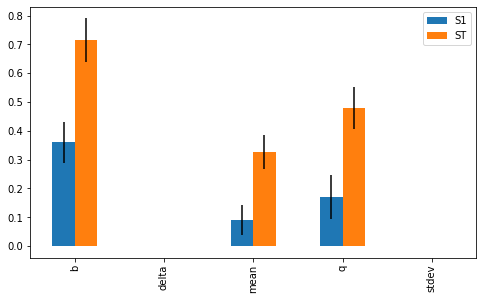

In [9]:
# Show the results of the sobol sensitivity analysis on the 0 policy
Si = sobol.analyze(SA_lib_problem, policy0['reliability'].to_numpy())
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

### Conclusion from the plot
In the plot it can be seen that for b, the mean and for q the ST value is substatialiy higher than S1. This means that interaction effects are present between the variables and a linear regression model as sensitivity analysis would not be sufficient.

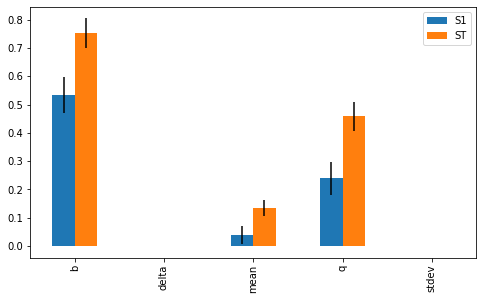

In [10]:
# Show the results of the sobol sensitivity analysis on the 0.05 policy
Si = sobol.analyze(SA_lib_problem, policy005['reliability'].to_numpy())
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

Compared to the 0 policy, what stands out is that the variance on the mean is lower in the 0.05 scenario. Also, the difference between S1 and ST is smaller in this graph, showing that interaction effects on the mean is lower. Furthermore, not many differences can be seen.

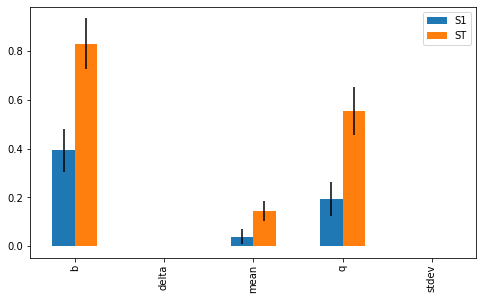

In [11]:
# Show the results of the sobol sensitivity analysis on the 0.1 policy
Si = sobol.analyze(SA_lib_problem, policy01['reliability'].to_numpy())
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

What stands out in the plot shown above is the very high value for sensitivity on b and the great difference between S1 and ST in all three variables.

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [12]:
# Calculate the sensitivity with the random forest method.
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment_trees, result_trees = evaluator.perform_experiments(
                                         scenarios=1000,
                                         policies = policy, 
                                         uncertainty_sampling='lhs')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [13]:
X = experiment_trees[['b', 'delta', 'q', 'stdev', 'policy']]
Y = pd.DataFrame(result_trees)

In [14]:
# Feature importance
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

importance = pd.DataFrame()
for i in X.policy.unique():
    X_df = X[X['policy'] == i]
    X_df = X_df.drop('policy',1)
    for key, value in result_trees.items():
        rd_trees = feature_scoring.get_rf_feature_scores(X,Y[key],mode = RuleInductionType.REGRESSION,nr_trees=100,                         max_features=0.6)
        result = rd_trees[0]
        result.columns = [key + ' Policy '+ str(i)]
        importance = pd.concat([importance, result], 1)
importance.reindex(sorted(importance.columns), axis=1)

,intertia Policy 0,intertia Policy 0.05,intertia Policy 0.1,max_P Policy 0,max_P Policy 0.05,max_P Policy 0.1,reliability Policy 0,reliability Policy 0.05,reliability Policy 0.1,utility Policy 0,utility Policy 0.05,utility Policy 0.1
0,,,,,,,,,,,,
b,0.0,0.0,0.0,0.666423,0.668954,0.673891,0.319498,0.322665,0.319366,0.003110,0.002937,0.003119
policy,0.0,0.0,0.0,0.191597,0.188595,0.189076,0.419613,0.413596,0.417342,0.703980,0.698684,0.699951
q,0.0,0.0,0.0,0.086516,0.086722,0.084019,0.200173,0.202154,0.200295,0.003019,0.003179,0.002419
delta,0.0,0.0,0.0,0.029511,0.028520,0.028361,0.031890,0.032687,0.033857,0.286662,0.292270,0.291240
stdev,0.0,0.0,0.0,0.025953,0.027209,0.024652,0.028826,0.028898,0.029140,0.003229,0.002929,0.003272


In [15]:
# Repeat the experiment with the Sobol experiments as input for the forest.
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment_SoTres, result_SoTres = evaluator.perform_experiments(
                                         scenarios=1000,
                                         policies = policy, 
                                         uncertainty_sampling='sobol')
X_Sobol = experiment_SoTres[['b', 'delta', 'q', 'stdev', 'policy']]
Y_Sobol = pd.DataFrame(result_SoTres)

importance1 = pd.DataFrame()
for i in X_Sobol.policy.unique():
    X_df = X_Sobol[X_Sobol['policy'] == i]
    X_df = X_df.drop('policy',1)
    for key, value in result_trees.items():
        rd_trees = feature_scoring.get_rf_feature_scores(X_Sobol,Y_Sobol[key],mode = RuleInductionType.REGRESSION,                          nr_trees=100, max_features=0.6)
        result = rd_trees[0]
        result.columns = [key + ' Policy '+ str(i)]
        importance1 = pd.concat([importance1, result], 1)
importance1.reindex(sorted(importance1.columns), axis=1)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


,intertia Policy 0,intertia Policy 0.05,intertia Policy 0.1,max_P Policy 0,max_P Policy 0.05,max_P Policy 0.1,reliability Policy 0,reliability Policy 0.05,reliability Policy 0.1,utility Policy 0,utility Policy 0.05,utility Policy 0.1
0,,,,,,,,,,,,
b,0.0,0.0,0.0,0.677360,0.677399,0.677280,0.321471,0.320386,0.325866,0.000253,0.000259,0.000244
policy,0.0,0.0,0.0,0.187028,0.187847,0.186417,0.425091,0.427456,0.422235,0.713124,0.700523,0.709831
q,0.0,0.0,0.0,0.083616,0.082797,0.084542,0.196017,0.194421,0.194449,0.000364,0.000310,0.000286
stdev,0.0,0.0,0.0,0.026704,0.026568,0.026752,0.029196,0.029475,0.029441,0.000363,0.000443,0.000379
delta,0.0,0.0,0.0,0.025292,0.025390,0.025009,0.028224,0.028262,0.028009,0.285895,0.298465,0.289260


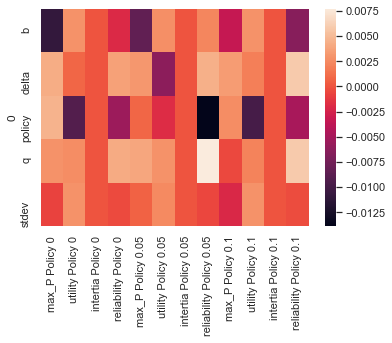

In [16]:
# Show heatmap to indicate where the major differences lie between the two methods.
imp_difference = importance - importance1
sns.set_theme()
ax = sns.heatmap(imp_difference)

In the plot it can be seen that for the most part, both methods seem to agree on the scores. On inertia, both methods have the exact same outcome. The largest difference can be seen in the reliability of the 0.1 policy, there the sobol method extimates policy significantly higher and 1 significantly lower than the 'classic' random forest.